## final project submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: https://clairesarraille.github.io/2021/08/08/kings_county_housing.html


Jeff Suggestions:
- Removing some of the outliers and try normalizing your features if you are still having a problem with heteroscedascity. 
- Most people on this project are getting a R^2 between 0.55 and 0.75
- Use another metric to measure model performance: Mean Squared Error

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline


## crisp-dm:

- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Normalize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will we use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model
    - The real estate agency I work for
- How will the model be used
    - Help a sub-set of home owners sell homes, by suggesting the most lucrative home renovations by their impact on home selling price.
- How will using the model help our business
    - We can give good advice to homeowners about how home renovations might increase the estimate value of their homes, and by how much
    - This will increase the amount of sales, thus increasing both our's and the home owner's profits
- clarify requirements
    - Find the features that are highest correlated with a higher sell price. Find how many dollars each unit of each feature adds to price
    - Use these correlations to recommend home renovations, ranked by the most to least positive impact on price.
- What problems are in and out of scope
    - How do home renovations impact the sell price of a home.
    - How locational factors impact price: homeowners cannot re-locate homes and we are assuming they can't change view of waterfront 

## Business Questions:
- Useful to subset data into waterfront vs. non-waterfront models?
- Remove outliers so that we're looking at average homes?
    - Average home in America has about 4 bedrooms
- If we normalize all of our predictors so they are on the same scale (z-score normalization), how do we un-normalize these features to interpret how they impact price?

# UNDERSTAND DATA
- What is **target**
>'price'
- What are **predictors**
>'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'
- Distribution of Data - See Distribution Section
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy? - See Data Quality Section

## Read in Data

In [ ]:
df = pd.read_csv('data/kc_house_data.csv')

## Remove Features - recommended by Flatiron to remove
- date (no explanatory value)
- view ( has been viewed, this wouldn't help us predict prices) 
- Note: **sqft_above + sqft_basement = sqft_living**, according to meta-data:
    - sqft_above (repeating sqft_living)
    - sqft_basement (repeating sqft_living)
- yr_renovated (repeating yr_built)
- Not helpful to have geographic features becuase renovation can't inclue re-locating house (ostensibly)
    - zipcode
    - lat
    - long
- sqft_living15 (repeating sqft_living)
- sqft_lot15 (repeating sqft_lot)

In [ ]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model
# Note: The brief for this project also recommended dropping these features.

df = df.drop(['date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [ ]:
# Note:sqft_living includes a finished basement, if present
# Grade is the construction quality of improvements, according to a King County grading system
# Condition is overall condition of house
df.columns

## Data Quality

- There could be outliers - such as hundreds of bathrooms - which doesn't make sense with square footage
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

### Waterfront Missing Values 
I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [ ]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

In [ ]:
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df['waterfront'].astype(int)
df['waterfront'].unique()

## Cast Features -- at a Different Scale for Visualization 

In [ ]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [ ]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [ ]:
df[['price_millions','price', 'acres_lot']]

In [ ]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

## DISTRIBUTIONS

### Clarify Grade and Condition Columns

#### King County's Grading System for Buildings:
##### Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1. Falls short of minimum building standards. Normally cabin or inferior structure.

2. Falls short of minimum building standards. Normally cabin or inferior structure.

3. Falls short of minimum building standards. Normally cabin or inferior structure.

4. Generally older, low quality construction. Does not meet code.

5. Low construction costs and workmanship. Small, simple design.

6. Lowest grade currently meeting building code. Low quality materials and simple designs.

7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#### King County's Condition Scale: 
##### Relative to age and grade. Coded 1-5.

1. Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2. Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4. Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5. Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Describe Data - Descriptive Statistics

In [ ]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'acres_lot': '{:.2f}',  'price': '{:20,.0f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

#### Interpret .describe() 
- There are no negative values for any of the columns
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.
- Condition and Grade: The mean, max, and min all line-up with the scale of the system, described above.
    - Mean Grade is 7.66, so between a 7 and 8: 
        - 7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.
        - 8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    - Mean Condition is 3.41, closest to a 3: 
        - 3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

In [ ]:
# Price Frequency Histogram before removing outliers, for context:
# Here we can see that the distribution of price, our target variable, has considerable right-skew
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(8,5))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


### Price Density Histogram

In [ ]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability for an interval of house prices.
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(df.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

For example, if we wanted to know the probability that a waterfront house price is between 1.00 and 1.75 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(1 \leq X \leq 1.75) = \int_{1}^{1.75} f_x(x) dx \geq 0 $$


### Narrow dataset for modeling 

In [ ]:
# Remember all columns in df are: 
df.columns

In [ ]:
# Select a subset of columns to create matrix:
df_all_cols = df.drop(['acres_lot','id'], axis=1)

In [ ]:
df_all_cols.columns

# DATA PREPARATION
- Prepping to model
- Missing values
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this because everything is ordinal and non-text)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Normalize numeric data


## Explore Multicollinearity
- This a phenemonen where two variables we are using as predictors are correlated with each other
- This violates one of the assumptions of performing linear regression - that all independent variables are independent from one another
- If we left all features in the model without addressing multicollinearity, it would become very hard for the model to estimate the relationship between independent variables and the dependent variable, because rather than change independently, the features would change in pairs or groups.

In [ ]:
correlations = df_all_cols.drop(['price'],axis = 1).corr()

In [ ]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [ ]:
correlations['price_millions'].sort_values(ascending=False)

In [ ]:
correlations["sqft_living"].sort_values(ascending=False)

### Correlations Interpretation 
- Features highly correlated with price are sqft_living, grade, and bathrooms
- Features highly correlated with sqft_living are grade, bathrooms, price_millions, and bedrooms

## Address Multicollinearity

In [ ]:
df_all_cols.columns

In [ ]:
df_all_cols.shape

In [286]:
# We want to write a simple loop to use statsmodel's variance_inflation_factort method on each array (row) of our dataframe, for each column 
# That's why we use X.shape[1] as the range in the loop below, since the second term in the output of the .shape method is the number of columns
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const          7601.443966
bedrooms          1.628887
bathrooms         3.186926
sqft_living       4.152240
sqft_lot          1.047462
floors            1.573844
waterfront        1.021879
condition         1.182857
grade             2.888261
yr_built          1.734538
dtype: float64

### sqft_living has a moderately high VIF value, followed by grade
- We can try removing sqft_living or grade to see if it improves our R-squared and Root Mean Squared Error values.

# df_all_cols - Linear Regression
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
    - Which models will we use
    - Will be use regularization?
    - How will we validate our model?
    - Loss functions?
    - What is the performance threshold for success?


## df_all_cols - statsmodels 
- First we'll use statsmodels.api to run a linear regression and examine model validation scores.
- We'll use all the independent variables (df_all_cols) for now.

In [ ]:
df_all_cols.columns

In [ ]:
# Add constant (AKA y-intercept):
# The constant is set to 1 as default - with means that our constant coefficient will be equal to 1*Beta(0)
# For our other variables (other Betas) will be multiplied by a particular coefficient to predict price
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
y = df_all_cols['price_millions']
X.head()

In [ ]:
# The order of the parameters is: endogenous response variable(dependent variable), exogenous variables(independent variables)
model_all_cols = sm.OLS(y,X).fit()

In [ ]:
model_all_cols.summary()

In [ ]:
# In addition to R-Squared and Adjusted R-Squared, we'll use Root Mean Squared Error to validate our model
# Here, our RMSE value is .047821 (million dollars) -- which heuristically can be thought of...
# ...as the normalized distance between our y values and our y-predicted values
# Thus, for any given prediction we make for a home price, we can expect to be about $47,821 off.
# Our model is failing to account for some important features underlying the data.
yhat = model_all_cols.predict(X)
model_rmse = mean_squared_error(y, yhat)
model_rmse

## df_all_cols - sklearn 

In [ ]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for the testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups
# So we have good proportions of randomly selected data and our 30-70 split has good representation 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

In [ ]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
# Library used: sklearn.linear_model
lr = LinearRegression(fit_intercept=True)

In [ ]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
# coef_list = list(lr.coef_)
# name_list = list(X_train.columns)
print(list(zip(lr.coef_, X_train.columns)))


In [ ]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [ ]:
# Training Data R-Squared Value:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

In [ ]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

### Interpret price vs. predicted price scatterplot:
- The distribution isn't a straight line, and from that we know that there is something non-linear going on in the relationships we've modeled. 
- We don't have a good linear relationship between price and our predictors

In [ ]:
# Predicted Price vs. Residuals
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation (difference between predicted and actual y values)

plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

In [ ]:
# Check Distribution of Errors:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [ ]:
# Finally, we take the 30% of that data we set aside for testing, and examine the R-squared value.
# Because the result (.653) is lower for our test data than our train data (.646), we could hypothesize that our model is under-fitting our data
# However, becasue plotting our residuals showed we haven't fulfilled some critical assumptions of linear regression...
# ... we can't really trust these values of R-squared.
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

Note:
Ultimately, if our model has a relatively low R-squared value (close to 50%), but we have:
1. fulfilled the assumptions of linear regression 
2. have normally distributed error 
3. coefficients have good p-values

... then we can still draw meaningful conclusions re: the relationships between the independent and dependent variables. Our coefficients will still represent the mean flucuation in the dependent variable for every one unit change in a given independent variable. 

## df_all_cols - Interpret
- Using all of our columns to predict price, and not subsetting the data at all:
- Our p-values are all 0.00, which is great.
- However, this model is violating necessary assumptions
    - The scatterplot of predicted price vs. price is clearly not a linear relationship
    - The plot of the residuals vs. the predicted price is a clear trumpet shape, which is highly heteroscedastic.
    - What we are aiming for is linearity and homoscedasticity - a fairly even distribution of the residuals vs. predicted price

# Log of Dependent Variable - Linear Regression 

## Log of Dependent Variable - statsmodels
If the distribution of the dependent variable is skewed, and doesn't follow a normal distribution, we can try to predict log(dependent variable) to improve our results.   

In [ ]:
# As we saw in our very first plot, the distribution of price has significant right-skew
y.hist()

In [ ]:
# When we plot the natural logarithm of price, the distribution is now more normally distributed
y_scld = np.log(y)
y_scld.hist();

In [ ]:
model_log = sm.OLS(y_scld, X).fit()
model_log.summary()

In [ ]:
# For any given prediction we make for a home price, we can expect to be about 1.10 million off. 
yhat = model_log.predict(X)
model_rmse_unscld = np.exp(mean_squared_error(y_scld, yhat))
model_rmse_unscld

## Log of Dependent Variable - sklearn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scld, test_size=0.3, random_state=4)

In [ ]:
lr.fit(X_train, y_train)
print(list(zip(lr.coef_, X_train.columns)))

In [ ]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [ ]:
# Training Data R-Squared Value:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

In [ ]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

In [ ]:
# Predicted Price vs. Residuals
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

In [ ]:
# Check Distribution of Errors:
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [ ]:
# R-Squared value for Testing Data:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

## Log of Dependent Variable - interpret

- The R-squared value for model_log (0.641) is slightly lower than that of df_all_cols (0.646)
- Our p-values are all 0.00 except for sqft_lot, which is 0.232
- Necessary assumptions for linear regression remain less than ideally fulfilled: 
    - The scatterplot of predicted price vs. price has some non-linearity 
    - The plot of the residuals vs. the predicted price is cone shaped

# Outliers Removed  
- Removing outliers can be a bit of an art, but given that my business case is to offer advice to mostly average, middle-class home owners, it makes sense to eliminate the priciest and lowest cost homes. 
- From the descriptive statistics we ran in the Understanding Data --> Distributions section, I surmised that the independent variables with the most unusual values were price and number of bedrooms. 

In [ ]:
# Here we take the absolute value of the z-scores for each value in columns "price" and "bedrooms" and filter our df by...
# ...only those values which have a z-score < 3
# df_rm_outliers = df_all_cols[(np.abs(stats.zscore(df_all_cols[['bedrooms']])) < 3)] 
# df_rm_outliers = df_all_cols[(np.abs(stats.zscore(df_all_cols[['price']])) < 2)]
# df = df[(np.abs(stats.zscore(df[['']])) < 2)] 
# df_rm_outliers = df_all_cols.loc[    (df_all_cols[(np.abs(stats.zscore(df_all_cols[['bedrooms']])) < 3)]) & (df_all_cols[(np.abs(stats.zscore(df_all_cols[['price']])) < 2)])]

df_rm_outliers = df_all_cols[ (np.abs(stats.zscore(df_all_cols[['bedrooms']])) < 1) & (np.abs(stats.zscore(df_all_cols[['price']])) < 2)]

In [ ]:
# Sort by Bedrooms:
df_rm_outliers[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living']].sort_values('bedrooms', ascending = False).head(10)

In [310]:
df_rm_outliers.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

In [312]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'price_millions': '{:,.8f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df_rm_outliers[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price_millions,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,yr_built
count,"20,756.00000000",20756.00,20756.00,"20,756.00",20756.00,20756.00000,20756.00,20756.00,20756
mean,0.48772620,3.34,2.07,"1,998.13",1.48,0.00299,3.41,7.56,1971
std,0.22445433,0.91,0.72,798.49,0.54,0.05457,0.65,1.06,29
min,0.07800000,1.00,0.50,370.00,1.00,0.00000,1.00,3.00,1900
25%,0.31700000,3.00,1.50,"1,407.25",1.00,0.00000,3.00,7.00,1951
50%,0.44000000,3.00,2.25,"1,870.00",1.00,0.00000,3.00,7.00,1974
75%,0.61327500,4.00,2.50,"2,460.00",2.00,0.00000,4.00,8.00,1996
max,1.27000000,33.00,7.50,"7,480.00",3.50,1.00000,5.00,12.00,2015


In [ ]:
# For our other variables (other Betas) will be multiplied by a particular coefficient to predict price
X = sm.add_constant(df_rm_outliers.drop(['price','price_millions'], axis=1))
y = df_rm_outliers['price_millions']
X.head()

In [ ]:
model_rm_outliers = sm.OLS(y, X).fit() 

In [ ]:
model_rm_outliers.summary()

In [ ]:
yhat = model_rm_outliers.predict(X)
model_rmse = mean_squared_error(y,yhat)
model_rmse

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

In [ ]:
lr.fit(X_train, y_train)
print(list(zip(lr.coef_, X_train.columns)))

In [ ]:
predict_y_train = lr.predict(X_train)

In [ ]:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

In [ ]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

In [ ]:
# Predicted Price vs. Residuals
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

In [ ]:
# Check Distribution of Errors:
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [ ]:
# R-Squared value for Testing Data:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

In [ ]:
# These values make a lot more sense
# The minimum and maximum values for price, bedrooms, and bathrooms are conceivable attributes of a middle class person's home.
# We didn't sacrifice on the size of our dataset, having only shed only about 4% of the number of rows in the original dataset.
df_rm_outliers[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

# Remove sqft_living

In [403]:
df_rm_outliers = df_all_cols.drop(['sqft_living','bathrooms'], axis=1)

In [404]:
# df_rm_outliers = df_all_cols[ (np.abs(stats.zscore(df_all_cols[['sqft_lot']])) < 3) & (np.abs(stats.zscore(df_all_cols[['price']])) < 3)]
df_rm_outliers = df_rm_outliers[(np.abs(stats.zscore(df_rm_outliers[['price_millions']])) < 3)]
# df_rm_outliers = df_rm_outliers[(np.abs(stats.zscore(df_rm_outliers)) < 3).all(axis=1)]

df_rm_outliers[['price_millions', 'bedrooms', 'sqft_lot']].sort_values('price_millions', ascending = False).head(10)

,price_millions,bedrooms,sqft_lot
15910,1.64,3,6765
2110,1.64,5,26784
14981,1.64,5,118047
15678,1.64,3,21164
13620,1.64,3,5445
8167,1.63,4,8112
17310,1.63,5,16583
14220,1.63,4,3600
7262,1.62,4,12281
2562,1.62,4,9750


In [405]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'price_millions': '{:,.8f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df_rm_outliers[['price_millions', 'bedrooms',  'floors',
    'waterfront', 'condition', 'grade', 'yr_built','sqft_lot']].describe().style.format(format_dict)

,price_millions,bedrooms,floors,waterfront,condition,grade,yr_built,sqft_lot
count,"21,191.00000000",21191.00,21191.00,21191.00000,21191.00,21191.00,21191,"21,191.00"
mean,0.50701029,3.36,1.49,0.00378,3.41,7.61,1971,"14,826.73"
std,0.25946221,0.92,0.54,0.06133,0.65,1.11,29,"40,400.95"
min,0.07800000,1.00,1.00,0.00000,1.00,3.00,1900,520.00
25%,0.32000000,3.00,1.00,0.00000,3.00,7.00,1951,"5,005.50"
50%,0.44700000,3.00,1.00,0.00000,3.00,7.00,1975,"7,560.00"
75%,0.62765000,4.00,2.00,0.00000,4.00,8.00,1996,"10,490.50"
max,1.64000000,33.00,3.50,1.00000,5.00,12.00,2015,"1,651,359.00"


In [406]:
X = sm.add_constant(df_rm_outliers.drop(['price','price_millions'], axis=1))
y = df_rm_outliers['price_millions']
model_rm_outliers = sm.OLS(y, X).fit() 
model_rm_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     3852.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:55:52   Log-Likelihood:                 7220.4
No. Observations:               21191   AIC:                        -1.442e+04
Df Residuals:                   21183   BIC:                        -1.436e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8103      0.099     48.756      0.000       4.617       5.004
bedrooms       0.0257      0.001     18.668      0.000       0.023       0.028
sqft_lot    1.712e-07   2.95e-08      5.799      0.000    1.13e-07    2.29e-07
floors         0.0484      0.003     18.059      0.000       0.043       0.054
waterfront     0.3411      0.019     17.652      0.000       0.303       0.379
condition      0.0246      0.002     12.469      0.000       0.021       0.028
grade          0.1780      0.001    134.164      0.000       0.175       0.181
yr_built      -0.0030    5.1e-05    -58.738      0.000      -0.003      -0.003
==============================================================================
Omnibus:                     3539.690   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8925.163
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       5.576   Cond. No.                     3.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [407]:
yhat = model_rm_outliers.predict(X)
model_rmse = mean_squared_error(y,yhat)
model_rmse

0.029619071502242814

In [408]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)
lr.fit(X_train, y_train)
print(list(zip(lr.coef_, np.exp(X_train).columns)))

[(0.0, 'const'), (0.0257928332389006, 'bedrooms'), (1.5696914900335443e-07, 'sqft_lot'), (0.051248750814433836, 'floors'), (0.36233116715720387, 'waterfront'), (0.026148237343844485, 'condition'), (0.17893454276317897, 'grade'), (-0.0030285856611997164, 'yr_built')]


In [409]:
predict_y_train = lr.predict(X_train)
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.5593124943395662


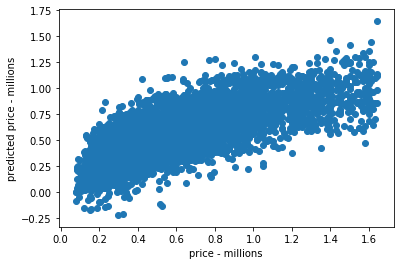

In [410]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

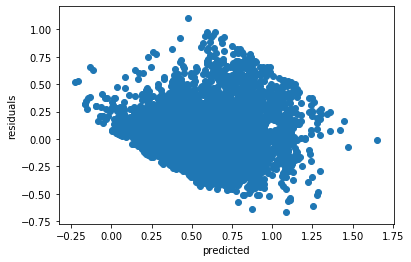

In [411]:
# Predicted Price vs. Residuals
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

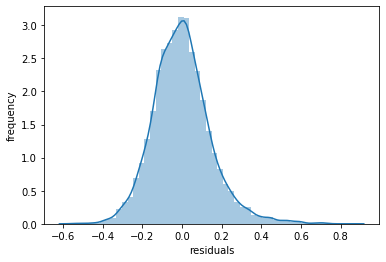

In [362]:
# Check Distribution of Errors:
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [363]:
# R-Squared value for Testing Data:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

The R squared value is: 0.5849795635033436
